In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset

from util.env import get_device, set_device
from util.preprocess import build_loc_net, construct_data
from util.net_struct import get_feature_map, get_fc_graph_struc

from evaluate import get_full_err_scores, get_best_performance_data, get_val_performance_data

from models.GDN import GDN

from train import train
from test import test

import os
import random
import math
from datetime import datetime
from pathlib import Path

from datasets.TimeDataset import TimeDataset

from sklearn.manifold import TSNE

In [457]:
dataset = 'msl'
slide_win = 15
slide_stride = 5
random_seed = 42
embed_dim = 64
batch = 8
topk = 20
dim = embed_dim
out_layer_num = 1
out_layer_inter_dim = 256
epoch = 30
decay = 0
val_ratio = 0.1
device = "cuda"

In [458]:
train_config = {
    'batch': batch,
    'epoch': epoch,
    'slide_win': slide_win,
    'dim': dim,
    'slide_stride': slide_stride,
    'comment': '',
    'seed': random_seed,
    'out_layer_num': out_layer_num,
    'out_layer_inter_dim': out_layer_inter_dim,
    'decay': decay,
    'val_ratio': val_ratio,
    'topk': topk,
}

env_config={
    'save_path': 'msl',
    'dataset': dataset,
    'report': 'best',
    'device': device,
    'load_model_path': ''
}

In [459]:
def get_score(test_result, val_result):

    feature_num = len(test_result[0][0])
    np_test_result = np.array(test_result)
    np_val_result = np.array(val_result)

    test_labels = np_test_result[2, :, 0].tolist()

    test_scores, normal_scores = get_full_err_scores(test_result, val_result)

    top1_best_info = get_best_performance_data(test_scores, test_labels, topk=1) 
    top1_val_info = get_val_performance_data(test_scores, normal_scores, test_labels, topk=1)


    print('=========================** Result **============================\n')

    info = None
    if env_config['report'] == 'best':
        info = top1_best_info
    elif env_config['report'] == 'val':
        info = top1_val_info

    print(f'F1 score: {info[0]}')
    print(f'precision: {info[1]}')
    print(f'recall: {info[2]}')
    print(f'auc score: {info[3]}')
    print(f'threshold: {info[4]}\n')

In [460]:
def get_save_path(feature_name=''):

    dir_path = 'msl'
    
    now = datetime.now()
    datestr = now.strftime('%m-%d-%H-%M-%S')         

    paths = [
        f'./pretrained/{dir_path}/best_{datestr}.pt',
        f'./results/{dir_path}/{datestr}.csv',
    ]

    for path in paths:
        dirname = os.path.dirname(path)
        Path(dirname).mkdir(parents=True, exist_ok=True)

    return paths

In [461]:
def get_loaders(train_dataset, seed, batch, val_ratio=0.1):
    dataset_len = int(len(train_dataset))
    train_use_len = int(dataset_len * (1 - val_ratio))
    val_use_len = int(dataset_len * val_ratio)
    val_start_index = random.randrange(train_use_len)
    indices = torch.arange(dataset_len)

    train_sub_indices = torch.cat([indices[:val_start_index], indices[val_start_index+val_use_len:]])
    train_subset = Subset(train_dataset, train_sub_indices)

    val_sub_indices = indices[val_start_index:val_start_index+val_use_len]
    val_subset = Subset(train_dataset, val_sub_indices)


    train_dataloader = DataLoader(train_subset, batch_size=batch,
                            shuffle=True)

    val_dataloader = DataLoader(val_subset, batch_size=batch,
                            shuffle=False)

    return train_dataloader, val_dataloader

In [462]:
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
os.environ['PYTHONHASHSEED'] = str(random_seed)

# Prepare Data

In [463]:
train_orig = pd.read_csv(f'./data/{dataset}/train.csv', sep=',', index_col=0)
test_orig = pd.read_csv(f'./data/{dataset}/test.csv', sep=',', index_col=0)

train_c, test_c = train_orig, test_orig

if 'attack' in train_c.columns:
    train_c = train_c.drop(columns=['attack'])

feature_map = get_feature_map(dataset)  # list of features (name of columns)
fc_struc = get_fc_graph_struc(dataset)  # fully-connected edge list

set_device("cuda")
device = get_device()

# create fully connected edges [2, N * (N - 1)]
fc_edge_index = build_loc_net(fc_struc, list(train_c.columns), feature_map=feature_map)
fc_edge_index = torch.tensor(fc_edge_index, dtype = torch.long)

train_dataset_indata = construct_data(train_c, feature_map, labels=0)
test_dataset_indata = construct_data(test_c, feature_map, labels=test_c.attack.tolist())

cfg = {
    'slide_win': slide_win,
    'slide_stride': slide_stride,
}

train_dataset = TimeDataset(train_dataset_indata, fc_edge_index, mode='train', config=cfg)
test_dataset = TimeDataset(test_dataset_indata, fc_edge_index, mode='test', config=cfg)

train_dataloader, val_dataloader = get_loaders(train_dataset, random_seed, batch, val_ratio = 0.1)
test_dataloader = DataLoader(test_dataset, batch_size=batch, shuffle=False, num_workers=0)

edge_index_sets = []
edge_index_sets.append(fc_edge_index)

In [464]:
node_num = len(feature_map)
edge_set_num = len(edge_index_sets)

# Train GDN

In [465]:
gdn = GDN(edge_index_sets, node_num, 
          dim=dim, 
          input_dim=slide_win, 
          out_layer_num=out_layer_num, 
          out_layer_inter_dim=out_layer_inter_dim, 
          topk=topk
          ).to(device)

In [466]:
model_save_path = get_save_path()[0]
model_save_path

'./pretrained/msl/best_07-16-18-09-49.pt'

In [467]:
load_model_path = './pretrained/msl/best_07-16-18-03-41.pt'

In [468]:
if len(load_model_path) == 0:
    train_log = train(gdn, model_save_path, 
                      config=train_config, 
                      train_dataloader=train_dataloader, 
                      val_dataloader=val_dataloader, 
                      feature_map=feature_map, 
                      test_dataloader=test_dataloader, 
                      train_dataset=train_dataset, 
                      test_dataset=test_dataset,
                      dataset_name=env_config['dataset'])
else:
    gdn.load_state_dict(torch.load(load_model_path))

# Get Score

In [469]:
_, test_result = test(gdn, test_dataloader)

In [470]:
_, val_result = test(gdn, val_dataloader)

In [471]:
get_score(test_result, val_result)

=========================** Result **============================

F1 score: 0.8900083963056256
precision: 0.8057809330628803
recall: 0.993125
auc score: 0.5777563364055299
threshold: 0.5894504741002586



In [472]:
test_predicted_list, test_ground_list, test_labels_list = test_result

In [473]:
pred = np.array(test_predicted_list)
true = np.array(test_ground_list)
labels = np.array(test_labels_list)

print(pred.shape)
print(true.shape)
print(labels.shape)

(2034, 27)
(2034, 27)
(2034, 27)


In [474]:
pred[:, 0].shape

(2034,)

In [475]:
train_c.columns

Index(['M-6', 'M-1', 'M-2', 'S-2', 'P-10', 'T-4', 'T-5', 'F-7', 'M-3', 'M-4',
       'M-5', 'P-15', 'C-1', 'C-2', 'T-12', 'T-13', 'F-4', 'F-5', 'D-14',
       'T-9', 'P-14', 'T-8', 'P-11', 'D-15', 'D-16', 'M-7', 'F-8'],
      dtype='object')

# Plot Node Embeddings

In [476]:
learned_embeddings = gdn.embedding(torch.arange(0, node_num).to(device)).cpu().detach().numpy()
learned_embeddings.shape

(27, 64)

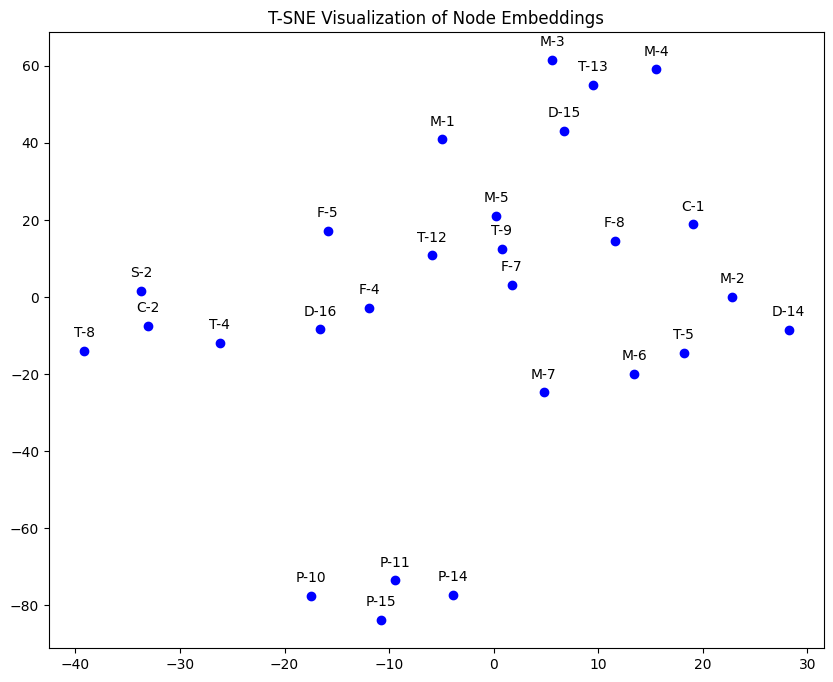

In [477]:
tsne = TSNE(n_components=2, perplexity=5, random_state=random_seed)
embeddings_2d = tsne.fit_transform(learned_embeddings)

plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c='blue', marker='o')

for i, label in enumerate(feature_map):
    plt.annotate(label, (embeddings_2d[i, 0], embeddings_2d[i, 1]), textcoords='offset points', xytext=(0, 10), ha='center')

plt.title('T-SNE Visualization of Node Embeddings')
plt.show()

# Plot Anaomaly Based on Error Score

In [478]:
val_pred_list, val_true_list, val_labels_list = val_result
val_pred_array = np.array(val_pred_list)
val_true_array = np.array(val_true_list)
val_labels_array = np.array(val_labels_list)

print(val_pred_array.shape)
print(val_true_array.shape)
print(val_labels_array.shape)

(31, 27)
(31, 27)
(31, 27)


In [479]:
def get_error_score(pred:list, true:list) -> np.array:
    pred_array = np.array(pred)
    true_array = np.array(true)

    # error score
    delta = np.abs(pred_array - true_array)
    delta_t = delta.T
    # median and iqr
    median = np.median(delta_t, axis=1)
    q75, q25 = np.percentile(delta_t, [75, 25], axis=1)
    iqr = q75 - q25
    
    epsilon = 1e-4
    normalized_error_score = (delta - median) / (np.abs(iqr) + epsilon)

    smoothed_error_score = np.zeros(normalized_error_score.shape)
    before_num = 3
    for i in range(before_num, len(normalized_error_score)):
        smoothed_error_score[i] = np.mean(normalized_error_score[i - before_num: i + 1], axis=0)

    return smoothed_error_score

In [480]:
val_error_score = get_error_score(val_pred_list, val_true_list)
val_error_score.shape

(31, 27)

In [481]:
thresholds = np.max(val_error_score, axis=0)
thresholds.shape
thresholds

array([1.06162651, 1.04254984, 0.7335456 , 1.00159787, 1.25438127,
       1.02956078, 1.07611002, 2.97763525, 1.8378824 , 1.60135905,
       1.58611014, 0.79215456, 2.36466163, 0.77912508, 0.44380207,
       1.37202598, 3.104393  , 2.16868326, 0.87887594, 1.02428834,
       1.24793225, 3.13754406, 1.40029212, 3.68626893, 4.74662218,
       3.6248177 , 4.43822651])

In [482]:
test_error_score = get_error_score(test_predicted_list, test_ground_list)

In [483]:
test_error_score

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.74881931e+02, 6.41920593e-01, 2.67514411e+01, ...,
        1.07551607e+02, 1.33571579e+03, 9.30106266e+01],
       [1.74881931e+02, 9.43086511e-01, 2.71579917e+01, ...,
        1.08041289e+02, 1.33571582e+03, 9.30106304e+01],
       [1.74881931e+02, 1.24585782e+00, 2.75632125e+01, ...,
        1.08536496e+02, 1.33571584e+03, 9.30106341e+01]])

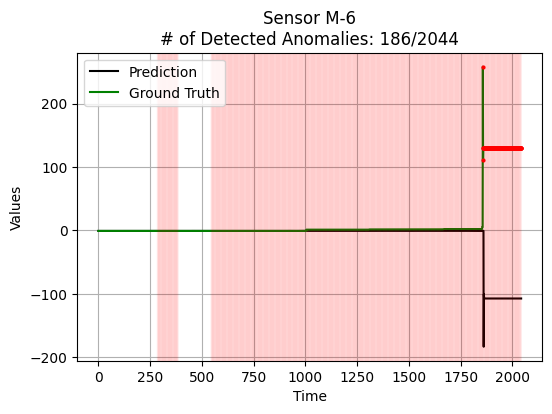

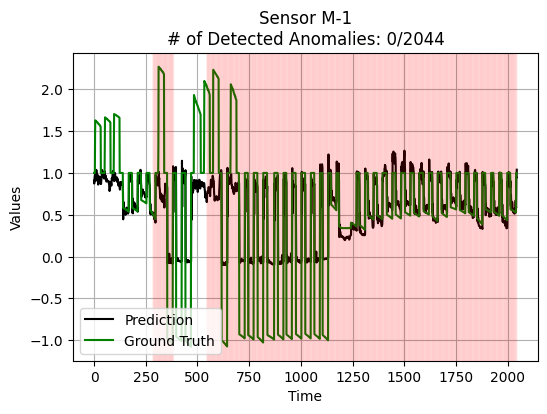

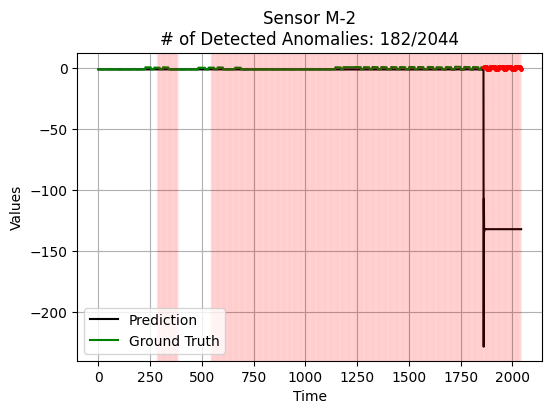

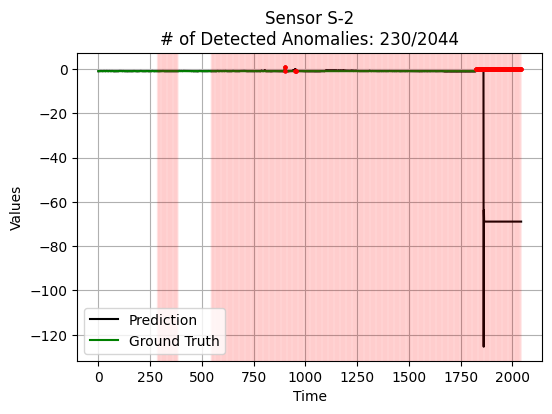

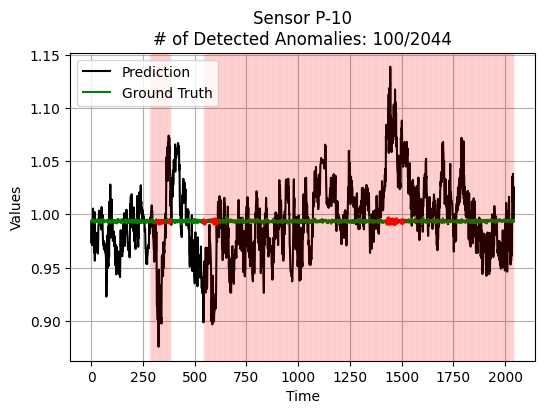

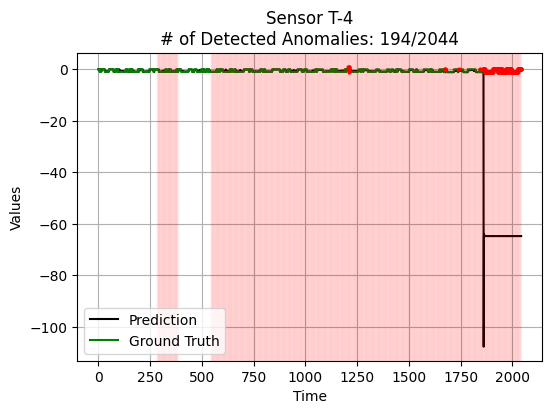

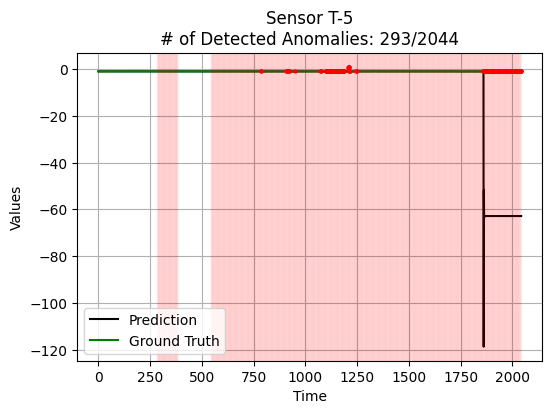

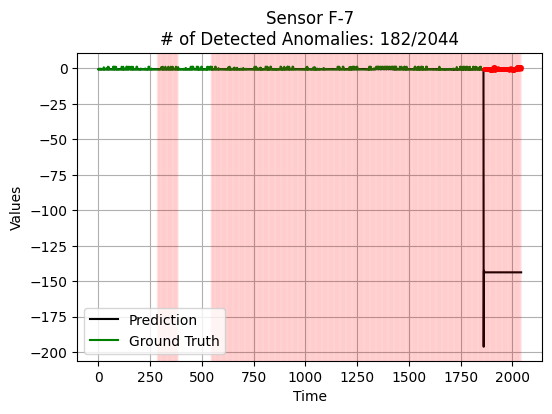

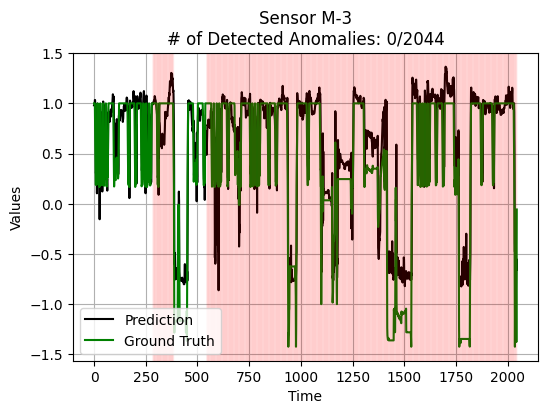

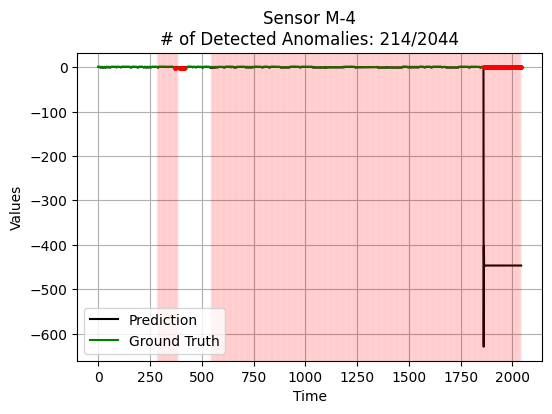

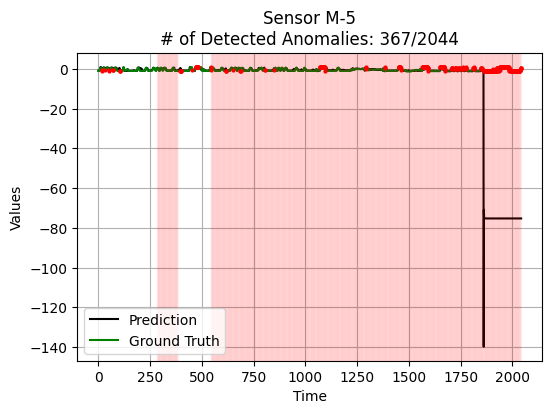

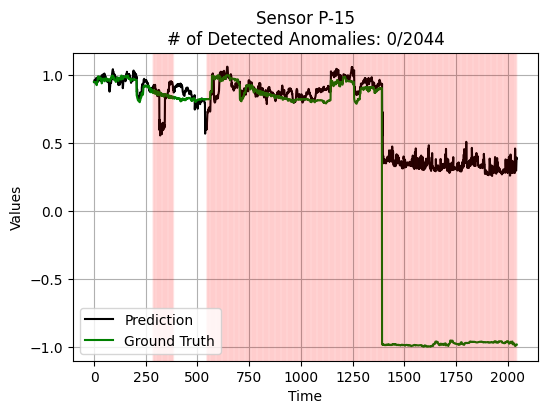

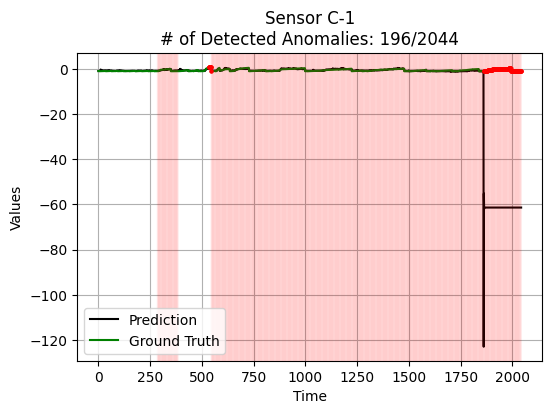

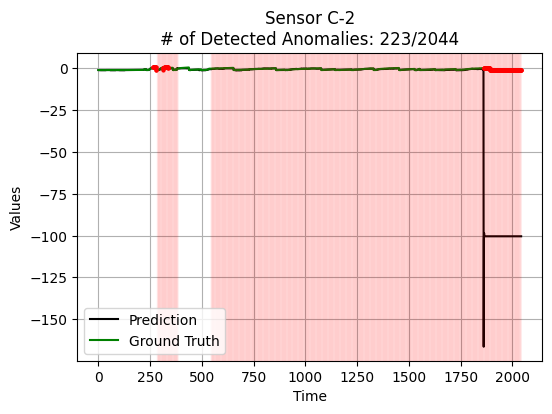

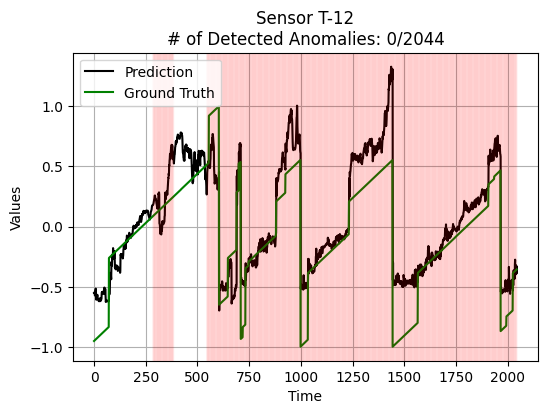

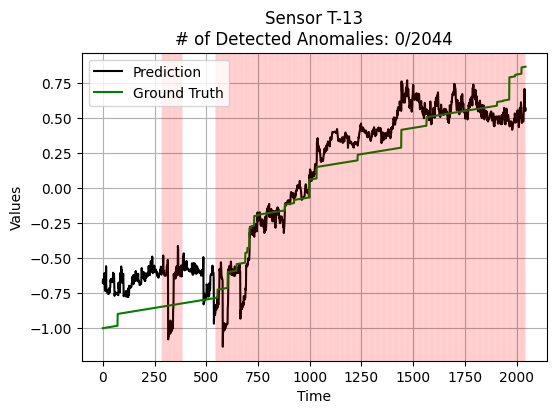

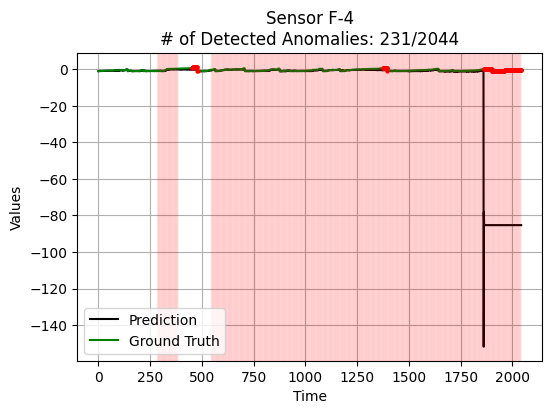

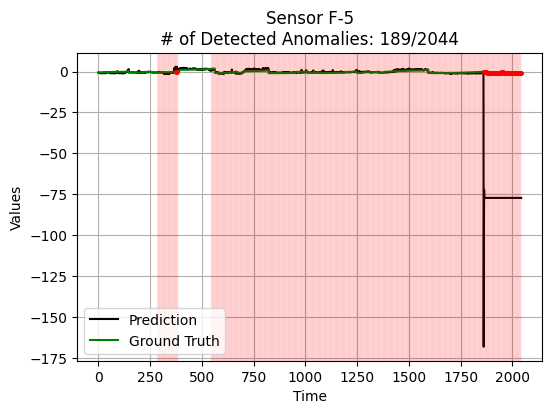

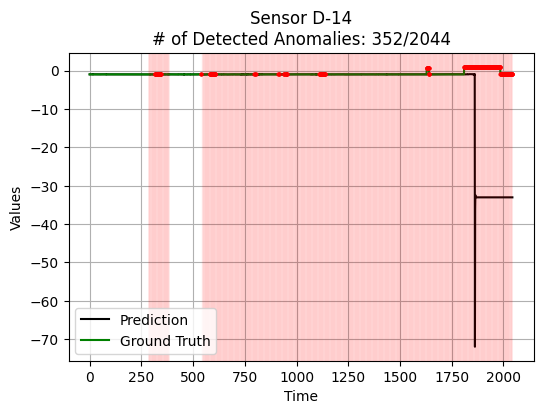

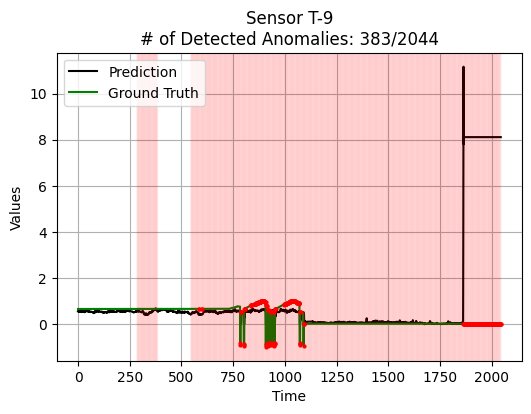

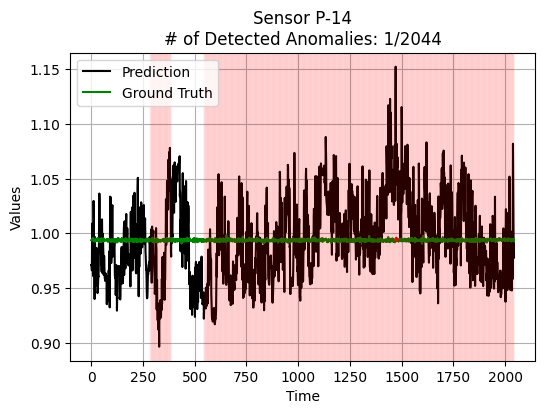

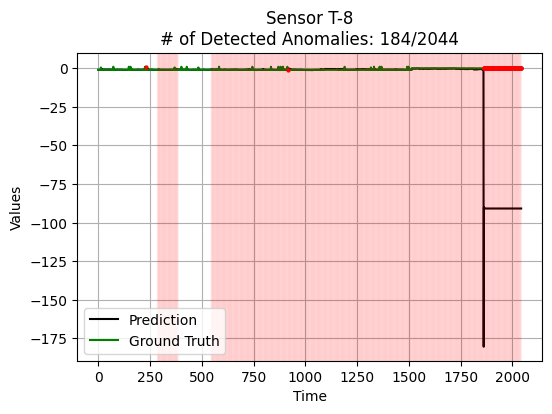

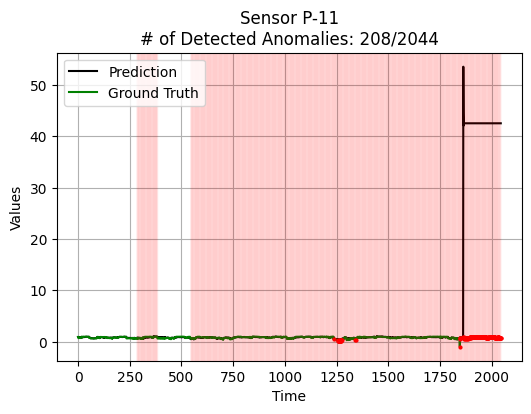

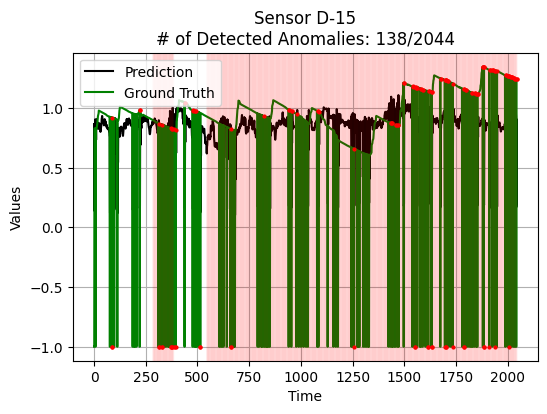

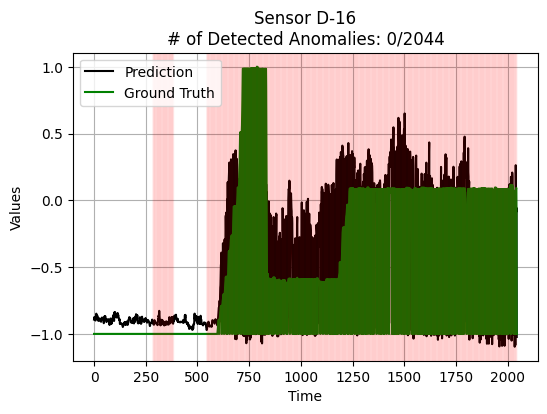

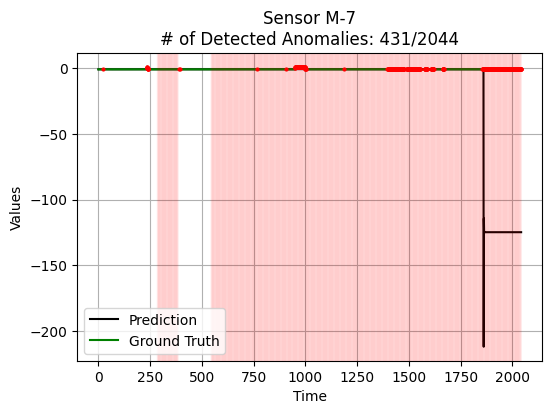

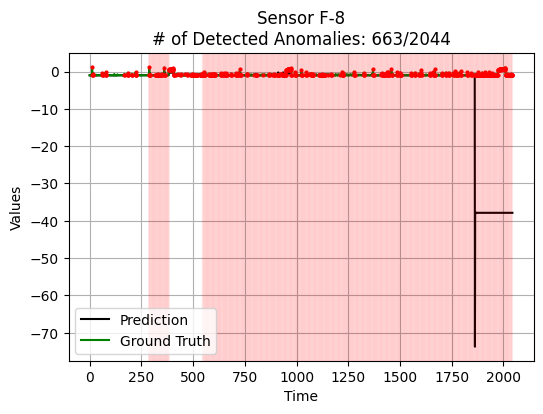

In [101]:
time_points = np.arange(pred.shape[0])

anomaly = np.zeros(true.shape, dtype=int)

for sensor in range(pred.shape[1]):
    sensor_pred_array = pred[:, sensor]
    sensor_true_array = true[:, sensor]
    sensor_label_array = labels[:, sensor]
    
    plt.figure(figsize=(6, 4))
    plt.grid(True)
    plt.plot(time_points, sensor_pred_array, label="Prediction", c='black')
    plt.plot(time_points, sensor_true_array, label="Ground Truth", c='green')
    
    for t in time_points:
        if sensor_label_array[t] == 1.0:
            plt.axvline(x=t, color='red', alpha=0.02)

        if test_error_score[t][sensor] > thresholds[sensor]:
            plt.plot(t, sensor_true_array[t], 'ro', markersize=2)
            anomaly[t][sensor] = 1
    
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.title(f"Sensor {train_c.columns[sensor]}\n# of Detected Anomalies: {np.sum(anomaly[:, sensor])}/{time_points.shape[0]}")
    plt.legend()
    plt.show()

# Draw Graph with Attention Weights

In [484]:
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.utils import remove_self_loops, add_self_loops
import networkx as nx

In [492]:
indices = (edge_index[1] == 0).nonzero(as_tuple=True)[0]
indices

tensor([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
          12,   13,   14,   15,   16,   17,   18, 3591])

In [495]:
edge_index

tensor([[  6,  25,  18,  ..., 186, 187, 188],
        [  0,   0,   0,  ..., 186, 187, 188]])

In [497]:
27 * 8

216

In [499]:
attention_weights = torch.zeros((len(feature_map), topk))

edge_index = gdn.gnn_layers[0].edge_index_1.cpu().detach()
attention_weight = gdn.gnn_layers[0].att_weight_1[:, 0, 0].cpu().detach()

for b in range(batch):
    start = b * len(feature_map)
    for sensor in range(start, len(feature_map) + start):
        indices = (edge_index[1] == sensor).nonzero(as_tuple=True)[0]
        if len(indices) == 0:
            break
        attention_weights[sensor - start] += attention_weight[indices]

attention_weights /= batch

In [500]:
edge_index_without_self_loop, _ = remove_self_loops(edge_index[:, :len(feature_map) * (topk - 1)])

In [501]:
edge_attr = attention_weights[:, :-1].flatten().unsqueeze(1)

In [502]:
learned_embeddings.shape

(27, 64)

In [503]:
weights = attention_weights[:, :-1].numpy()
min_weights = weights.min(axis=1).reshape(-1, 1)
max_weights = weights.max(axis=1).reshape(-1, 1)
norm_weights = (weights - min_weights) / (max_weights - min_weights)

In [504]:
edge_attr = norm_weights.flatten().reshape(-1, 1)
norm_weights = norm_weights.flatten()

In [505]:
graph = Data(x=learned_embeddings, edge_index=edge_index_without_self_loop, edge_attr=edge_attr)

In [506]:
graph

Data(x=[27, 64], edge_index=[2, 513], edge_attr=[513, 1])

In [507]:
g = torch_geometric.utils.to_networkx(graph, edge_attrs=['edge_attr'])

In [508]:
labeldict = {idx: feature_map[idx] for idx in range(len(feature_map))}

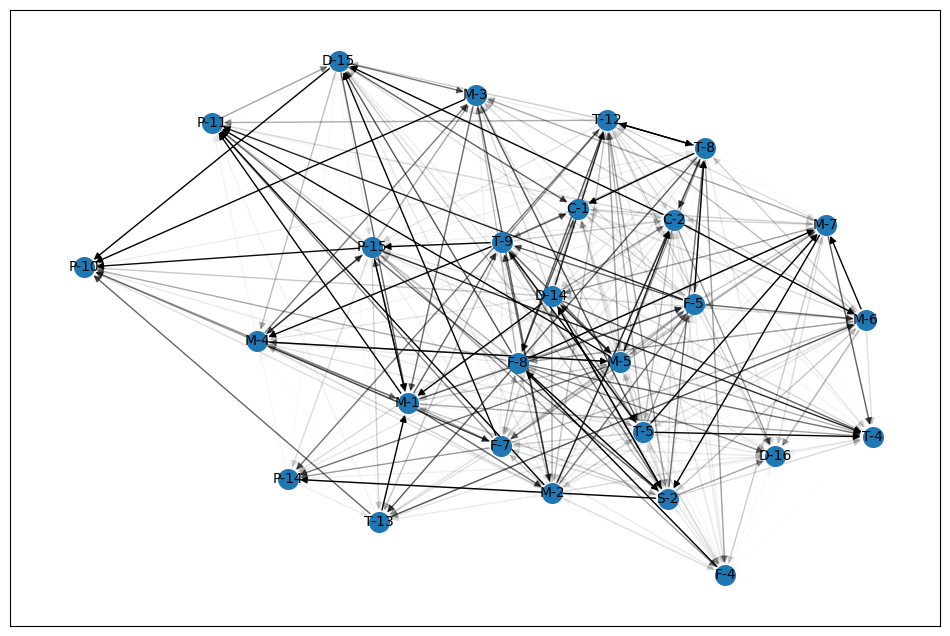

In [509]:
plt.figure(figsize=(12, 8))

pos = nx.spring_layout(g)

nx.draw_networkx_nodes(g, pos, node_size=200)

for i, (u, v, d) in enumerate(g.edges(data=True)):
    opacity = norm_weights[i]
    nx.draw_networkx_edges(g, pos, edgelist=[(u, v)], alpha=opacity, edge_color='black')

nx.draw_networkx_labels(g, pos, font_size=10, labels=labeldict)

plt.show()

4320